# Определение стоимости автомобилей

Сервис по продаже автомобилей разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания (RMSE < 2500) 
- скорость предсказания
- время обучения

## Подготовка данных

In [1]:
#импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import re
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import KFold, GridSearchCV, train_test_split

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### Общая информация

In [2]:
data = pd.read_csv('datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год выпуска автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л.с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц выпуска автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

In [5]:
month = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S').max().month 
month = ['январе', 'феврале', 'марте', 'апреле', 'мае', 'июне', 
         'июле', 'августе', 'сентябре', 'октябре', 'ноябре', 'декабре'         
        ][month - 1]
print('Данные скачаны в',
      month,
      pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S').max().year,
      'года.'
     )

length = len(data)

print('Всего', length, 'строк.')

Данные скачаны в апреле 2016 года.
Всего 354369 строк.


### Предобработка данных

Для удобства переведем названия столбцов в змеиный регистр:

In [6]:
def serpensortia(name):
    new_name = re.findall('[A-Z][^A-Z]*', name)
    new_name = [word.lower() for word in new_name]
    return '_'.join(new_name)
    
data.columns = [serpensortia(name) for name in list(data.columns)]
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Проверим наличие дубликатов:

In [7]:
print('Всего', data.duplicated().sum(), 'дубликата.')
data = data.drop_duplicates()

Всего 4 дубликата.


Почтовый индекс владельца `postal_code`, дата скачивания анкеты `data_crawled` и дата последней активности пользователя`last_seen` не несут информации, определяющей стоимость автомобиля. Необходимо убрать их из данных.

In [8]:
data = data.drop(['postal_code', 'date_crawled', 'last_seen'], axis=1)

Столбец `date_created` должен имет тип *datetime*:

In [9]:
data['date_created'] = pd.to_datetime(data['date_created'], format='%Y-%m-%d %H:%M:%S')

Проведем обработку пропусков.

In [10]:
data.isna().sum()

price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
dtype: int64

Пропуски присутствуют в столбцах `vehicle_type`, `gearbox`, `model`, `fuel_type` и `repaired`. В первую очередь рассмотрим пропуски в столбце `model`. Для многих марок присутствует модель `other`. Заполним пропуски этим значением:

In [11]:
data['model'] = data['model'].fillna('other')

Признаки `vehicle_type`, `gearbox` и `fuel_type` можно было бы попробовать восстановить на основе названия марки и модели, однако модели выпускаются в разных комплектациях, поэтому и тип кузова, и тип коробки передач, и тип топлива могут быть разными для одной и той же модели. Поэтому заполним пропуски наиболее часто встречающимся значением. Однако для неизвестных моделей типа `other` нельзя так поступать, поэтому оставшиеся пропуски тоже заполним значением `other`.

In [12]:
data = data.fillna({'vehicle_type': 'other'})
data['full_name'] = data['brand'] + ' ' + data['model'] +' ' +  data['vehicle_type']

def fill_nan_by_model(data, col):
    names = data.loc[data[col].isna(), 'full_name'].unique()
    for name in names:
        if name[-13:] != 'other other':#to be sure it is the only one model
            filler = data.loc[(data['full_name'] == name), col].value_counts()
            if len(filler) > 1:
                data.loc[(data['full_name'] == name) & (data[col].isna()), col] = filler.idxmax()
            

for col in ['gearbox', 'fuel_type']:
    fill_nan_by_model(data, col)
    data = data.fillna({col: 'other'})
    
data = data.drop('full_name', axis=1)

In [13]:
data.isna().sum()

price                     0
vehicle_type              0
registration_year         0
gearbox                   0
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type                 0
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
dtype: int64

Остались только пропуски в `repaired`. 

In [14]:
data['repaired'].isna().sum()

71154

Пропусков достаточно много. Рассмотрим значения столбца:

In [15]:
data['repaired'].value_counts()

no     247158
yes     36053
Name: repaired, dtype: int64

Очевидно, что машины бывают в ремонте довольно редко. Логично предположить, что по умолчанию машина не была в ремонте. Заполним пропуски значением `no`.

In [16]:
data['repaired'] = data['repaired'].fillna('no')

Прверим оставшиеся пропуски.

In [17]:
data.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
dtype: int64

Прпусков больше нет.

В данных есть две даты: дата создания анкеты и год и месяц выпуска автомобиля. Для автомобиля важна не сама дата выпуска, а время эксплуатации. Его можно определить как время между датой создания анкеты и датой выпуска авто. Так как нам недоступен день выпуска, будем измерять срок эксплуатации в месяцах.

In [18]:
data['age'] = (data['date_created'].dt.year - data['registration_year']) * 12 + \
              data['date_created'].dt.month - data['registration_month']

### Обработка аномальных значений

In [19]:
data['registration_year'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

Наибольшее и наименьшее значения года выходят за рамки нашго исторического периода. Рассмотрим подробнее гистограмму для актуальных дат:

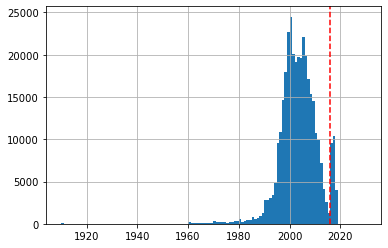

In [20]:
fig, ax = plt.subplots()
data['registration_year'].hist(bins=120, range=(1910, 2030))
ax.axvline(x=2016, color='r', linestyle='--') #add 2016 year level

In [21]:
data.loc[(data['registration_year'] >= 2015) & (data['registration_year'] < 2020),'registration_year'].value_counts()

2017    10441
2016     9599
2018     3959
2015     1302
2019       25
Name: registration_year, dtype: int64

Разброс в данных по значениям велик(от 1000 до 10000). В реальности автомобилей старше 1960 года практически нет. Данные собраны в апреле  2016 года, однако после 2016 года наблюдается выброс значений. После 2020 года данных почти нет. Подробнее рассмотрим данные за 2017-1019 гг. Маловероятно, что производится продажа еще не выпущенных автомобилей. К сожалению, такие данные с аномальными значениями не могут быть использованы для обучения. 

In [22]:
drop_indexes = data.loc[(data['registration_year'] < 1960) | (data['age'] < 0)].index
data = data.drop(drop_indexes)

Рассмотрим данные `power`.

In [23]:
data['power'].describe()

count    334183.000000
mean        111.446348
std         183.766599
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Реальные автомобили, не могут иметь 20 000 л.с. Рекорд мощности для спорткаров - примерно 2000 л.с.

<AxesSubplot:>

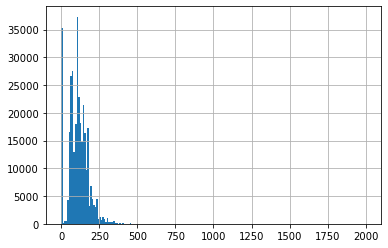

In [24]:
data['power'].hist(bins=200, range=(0, 2_000))

Очевидно, что авто с можностью > 500 л.с. практически нет. Уберем данные с большей мощностью.

In [25]:
drop_indexes = data[data['power'] > 500].index
data = data.drop(drop_indexes)

Мощности 0 л.с. тоже не может быть. Удалим и их.

In [26]:
drop_indexes = data[data['power'] == 0].index
data = data.drop(drop_indexes)

Рассмотрим данные `number_of_pictures`.

In [27]:
data['number_of_pictures'].unique()

array([0], dtype=int64)

У всех авто отсутствуют фотографии. Столбец неинформативен, избавимся от него.

In [28]:
data = data.drop('number_of_pictures', axis=1)

Рассмотрим данные о пробеге.

<AxesSubplot:>

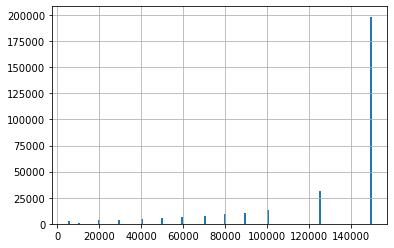

In [29]:
data['kilometer'].hist(bins=150)

Значения пробега дискретные, однако аномальных значений нет. 

Рассмотрим цены автомобилей.

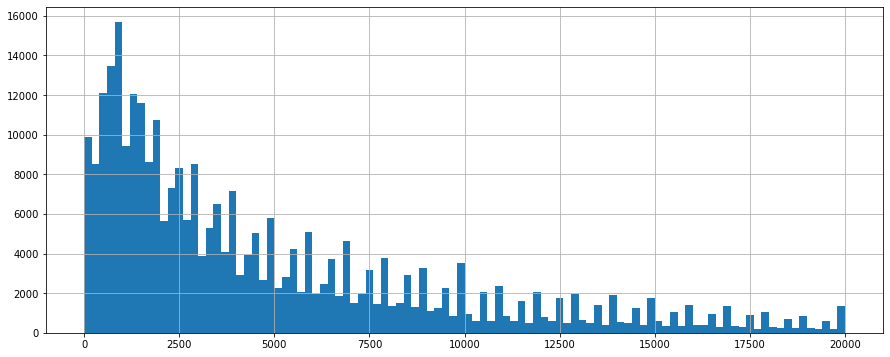

In [30]:
data['price'].hist(bins=100, figsize=(15, 6))
None

In [31]:
data['price'].describe().round()

count    298789.0
mean       4778.0
std        4622.0
min           0.0
25%        1250.0
50%        3000.0
75%        6950.0
max       20000.0
Name: price, dtype: float64

В целом по мере увеличения цены, количество атомобилей уменьшается. Также видна тендеция к округлению: цен, кратных 500, больше, чем соседних цен. 

Половина машин имеет стоимость не более 2850€. Присутствуют автомобили с заявленной стоимостью 0€. Низкая стоимость возможна, например, при обмене. Однако реальная стоимость подобных машин не может быть так мала, и пользователи вряд ли захотят увидеть околонулевую цену. Поэтому для улучшения качества обучения исправим эти данные. Для автомобилей стоимостью ниже 100€ будем использовать среднюю стоимость аналогичных машин: те же марка, модель, год выпуска и наличие ремонта. Оставшиеся низкие цены удалим.

In [32]:
data.loc[data['price'] < 100, 'price'] = np.NaN

columns = ['brand', 'model', 'repaired', 'registration_year']
avg_prices = data[columns + ['price']].groupby(columns)

data['price'] = data['price'].fillna(avg_prices['price'].transform('mean'))
data = data.dropna(subset=['price'])

In [33]:
(data['price'] < 100).sum()

0

Сейчас в данных присудствуют столбцы, отвечающие за время: `date_created`, `registration_year`, `registration_month` и `age`.   Год и месяц выпуска модели стоит сохранить, так как модели могут отличаться в зависимости от него. Так же возраст автомобиля влияет на его стоимость. Данные по дате создания мы использовали для создания столбца `age`, а сами по себе они мало влияют на цену, поэтому избавимся от них.

In [34]:
data = data.drop('date_created', axis=1)

### Вывод

На этапе предобработки были сделаны следующие изменения:

 - проведена проверка на дубликаты

 - названия столбцов приведены к единому формату
 
 - удалены неинформативные столбцы

 - исследованы пропуски в столбцах. Там, где возможно, данные восстановлены. 

 - был введен дополнительный столбец с данными - `age`, содержащий возраст автомобиля в месяцах.
 
 - исследованы численные данные на наличие аномальных значений. При возможности такие данные были исправлены либо удалены.

In [35]:
print('Удалено ', round((length - len(data))/length * 100), '% данных.', sep='')

Удалено 16% данных.


## Обучение моделей

### Подготовка признаков

В данных есть категориальные признаки:

- `vehicle_type` — тип автомобильного кузова
- `gearbox` — тип коробки передач
- `model` — модель автомобиля
- `fuel_type` — тип топлива
- `brand` — марка автомобиля
- `repaired` — была машина в ремонте или нет

Для всех категориальных признаков необходимо провести кодировку.

В данных `repaired` только 2 значения: `yes` - 1 и `no` - 0. 

In [36]:
data['repaired'] = data['repaired'].replace({'no': 0, 'yes': 1})

Преобразуем категориальные признаки 'vehicle_type', 'gearbox' и 'fuel_type' в численные при помощи OHE:

In [37]:
categorical = ['vehicle_type', 'gearbox', 'fuel_type']

from sklearn.compose import make_column_transformer
transformer = make_column_transformer(
    (OneHotEncoder(), categorical),
    remainder='passthrough')

transformed = transformer.fit_transform(data)
data = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)

In [38]:
drop_columns = ['onehotencoder__x0_other', 'onehotencoder__x1_other', 'onehotencoder__x2_other']
data = data.drop(drop_columns, axis=1)

Для признаков `brand` и `model` нельзя использовать OHE, так как будет создано порядка 300 дополнительных признаков, что значительно усложнит задачу. Воспользуемся порядковым кодированием.

Тестовая выборка отсутствует, значит, имеющиеся данные нужно разбить на три выборки: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разобьем в соотношении 3:1:1.

In [39]:
target = data['price']
features = data.drop('price', axis = 1)

# отделяем обучающую выборку - 60% всех данных
features, features_train, target, target_train = \
    train_test_split(features, target, test_size=.6, random_state=12345)

# делим оставшиеся данные на равные валидационную и тестовую выборки
features_valid, features_test, target_valid, target_test = \
    train_test_split(features, target, test_size=.5, random_state=12345)

print('Обучающая выборка:', features_train.shape[0], 'строк')
print('Валидационная выборка:', features_valid.shape[0], 'строк')
print('Тестовая выборка:', features_test.shape[0], 'строк')

Обучающая выборка: 179201 строк
Валидационная выборка: 59733 строк
Тестовая выборка: 59733 строк


In [40]:
encoder = OrdinalEncoder()
features_train[['brand', 'model']] = encoder.fit_transform(features_train[['brand', 'model']])
features_valid[['brand', 'model']] = encoder.transform(features_valid[['brand', 'model']])
features_test[['brand', 'model']] = encoder.transform(features_test[['brand', 'model']])

# int formatting for models training
for col in features_train.columns:
    features_train[col] = features_train[col].astype(int)
    features_valid[col] = features_valid[col].astype(int)
    features_test[col] = features_test[col].astype(int)

### Обучение моделей

В качестве возможных моделей рассмотрим 2 модели бустинга -  LightGBM и CatBoost и модель решающего дерева.

#### LightGBM

In [41]:
# %%time
# kf = KFold(n_splits=3, shuffle=True, random_state=1)

# params_lgbm = {"max_depth" : list(range(5, 15))}
# lgbm = LGBMRegressor()
# grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=params_lgbm, cv=kf, n_jobs=-1)
# grid_lgbm.fit(features_train, target_train)

# print("RMSE = ", mean_squared_error(target_valid, grid_lgbm.predict(features_valid))**(.5))

time_t = time.time()
lgbm = LGBMRegressor(max_depth=10)
lgbm.fit(features_train, target_train.astype(int))
time_t = time.time() - time_t
None

In [42]:
time_p = time.time()
predictions = lgbm.predict(features_valid)
time_p = time.time() - time_p

In [43]:
def check(rmse):
    print("RMSE =", int(rmse))
    if rmse > 2500:
        print('Модель не удовлетворяет требованиям.')
    else:
        print('Модель удовлетворяет требованиям.')
    

summary = {}
rmse_lgbm = mean_squared_error(target_valid, predictions)**(.5)
summary['LGBM'] = [time_t, time_p, int(rmse_lgbm)]

check(rmse_lgbm)

RMSE = 1655
Модель удовлетворяет требованиям.


#### CatBoost

In [44]:
# best_rmse = 10**6
# kf = KFold(n_splits=3, shuffle=True, random_state=1)
# params_cat = {"depth" : [i for i in range(5, 16)]}

# cat = CatBoostRegressor(iterations=300,  verbose=300)
# grid_cat = GridSearchCV(estimator=cat, param_grid=params_cat, cv=kf)
# grid_cat.fit(features_train, target_train)

# print(mean_squared_error(target_valid, grid_cat.best_estimator_.predict(features_valid))**(.5))
# grid_cat.best_params_

time_t = time.time()
kitty = CatBoostRegressor(iterations=500, depth=10, verbose=False)
kitty.fit(features_train, target_train)
time_t = time.time() - time_t
None

In [45]:
time_p = time.time()
predictions = kitty.predict(features_valid)
time_p = time.time() - time_p

In [46]:
rmse_kitty = mean_squared_error(target_valid, predictions)**(.5)
summary['CatBoost'] = [time_t, time_p, int(rmse_kitty)]

check(rmse_kitty)

RMSE = 1510
Модель удовлетворяет требованиям.


#### Дерево

In [47]:
# %%time
# tree_model = None
# tree_mse = 10000
# tree_max_depth = 0

# for depth in range(2,50):
#     model = DecisionTreeRegressor(max_depth=depth, random_state=1)
#     model.fit(features_train, target_train)
#     predictions_valid = model.predict(features_valid)
#     mse = mean_squared_error(target_valid, predictions_valid)**(.5)
#     if mse < tree_mse:
#         tree_model, tree_mse, tree_max_depth = model, mse, depth

# print(tree_mse)
# print(tree_max_depth)

time_t = time.time()
tree = DecisionTreeRegressor(max_depth=14, random_state=1)
tree.fit(features_train, target_train)
time_t = time.time() - time_t

In [48]:
time_p = time.time()
predictions = tree.predict(features_valid)
time_p = time.time() - time_p

In [49]:
rmse_tree = mean_squared_error(target_valid, predictions)**(.5)
summary['tree'] = [time_t, time_p, int(rmse_tree)]

check(rmse_tree)

RMSE = 1869
Модель удовлетворяет требованиям.


## Анализ моделей

### Выбор модели

In [50]:
pd.options.display.float_format = '{:,.2f}'.format #dataframe output formatting
pd.DataFrame(summary.values(),
             index=summary.keys(),
             columns=['Время обучения, с', 'Время предсказания, с', 'RMSE']
            )

,"Время обучения, с","Время предсказания, с",RMSE
LGBM,0.43,0.04,1655
CatBoost,14.76,0.06,1510
tree,0.77,0.02,1869


Все модели удовлетворяют требованиям. Лучшая метрика у модели CatBoost, но и время обучения и предсказания у нее наибольшее. У модели дерева же, наоборот, худшее качество, но лучшее время. В качестве рабочей модели используем модель CatBoost.

In [51]:
final_model = CatBoostRegressor(iterations=500, depth=10, verbose=False)
final_model.fit(pd.concat([features_train, features_valid]),
          pd.concat([target_train, target_valid])
         )
None

### Тестирование модели

Проверим модель на тестовой выборке.

In [52]:
predictions = final_model.predict(features_test)
rmse = mean_squared_error(target_test, predictions) ** .5

check(rmse)

RMSE = 1494
Модель удовлетворяет требованиям.


Рассмотрим, как сильно влияют признаки на итоговую стоимость.

<AxesSubplot:>

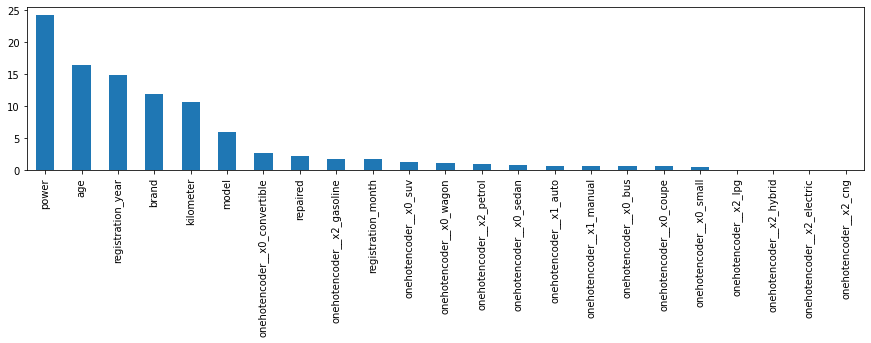

In [53]:
importances = final_model.feature_importances_
importances = pd.Series(importances, index=features_train.columns)

importances.sort_values(ascending=False).plot.bar(figsize=(15,3))

In [54]:
importances.sort_values(ascending=False)[:6]

power               24.31
age                 16.43
registration_year   14.95
brand               11.87
kilometer           10.67
model                5.91
dtype: float64

Самыми важными характеристиками, определяющими стоимость, являются мощность, возраст, год выпуска, марка, модель и пробег. Остальные признаки имеют гораздо меньший вклад. Заметим, что возраст, год выпуска и пробег характеризуют изношенность автомобиля, и можно сделать вывод, что физическое состояние является определяющим при формировании цены.

## Выводы

В рамках проекта была выполнена предобработка данных: были убраны лишние данные, заполнены пропуски. Данные были подготовлены для обучения: категориальные признаки были обработаны методами прямого кодирования и OHE. 

В качестве потенциальных моделей рассмотрены модели решающего дерева, LGBM и CatBoost. Для каждой из них были подобраны гиперпараметры для улучшения качества. Все модели удовлетворили требованию по метрике RMSE при проверке на валидационной выборке.

В качестве рабочей модели выбрана модель CatBoost, так как она имеет наименьшее значение RMSE, хоть и является самой медленной из всех. На тестовой выборке RMSE составила 1494, что удовлетворяет требованиям. 

После обучения рассмотрено, как признаки влияют на стоимость автомобиля. Определяющими являются мощность, возраст, год выпуска, марка, модель и пробег. 